# Classifying simulated events using a Convolutional Neural Network

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from helper_functions import import_data, normalize_image_data
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
# Load images and labels.
DATA_PATH = "../data/"

images = np.load(DATA_PATH+"images_training.npy")
labels = np.load(DATA_PATH+"labels_training.npy")

# Split the training indices into training and validation. 
# Validate with 25% of the data (default). Can be adjusted.
x_idx = np.arange(images.shape[0])
train_idx, val_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.25)

## Reshaping data for CNNs
The convolutional layers we'll be using expect the inputs to have 4 dimensions:\
(samples, M, N, channels).\
M and N are the image dimensions, 16x16, but while RGB images have 3 channels, ours currently has 0, but should have 1.\
We solve this by just adding an empty axis.

In [8]:
images = images[:, :, :, None]
print(images.shape)

(9000, 16, 16, 1)


# Model
Now, you can build your own network from scratch, and that's a useful exercise. We're going to skip that
here, and use one of the popular, exisiting frameworks that are widely used in current research.
The most used base frameworks are [TensorFlow](https://www.tensorflow.org/), [PyTorch](https://pytorch.org/), and [Keras](https://keras.io/). Keras is a high-level API that abstracts a large amount of the process of building,
training, and testing a model. You will need either TensorFlow or PyTorch, and the Keras API will automatically
detect which base framework you have.

## Build and compile

In [18]:
# Import the necessary TF models and layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

In [19]:
# Instantiate the Sequential model, and add layers to it.
model = Sequential()

# The model we build here is the one that has currently performed best when classifying the detector images.
model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape= (16,16,1)))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

In [22]:
# Once the model is built, we need to compile it. This is where we specify the loss function,
# optimizer, and any metrics we need, even custom ones.

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
dense_7 (Dense)              (None, 6, 6, 128)         8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)             

## Training
This is the point where we normalize our data, just as we pass it to the training function of the model.
The training run will display the progress as it goes through each batch.
$$ \text{num_batches} = \frac{\text{num_samples}}{\text{batch_size}}$$

In [23]:
# Set parameters for the training.
batch_size = 32
epochs = 20

In [25]:
# Setting validation data requires a tuple (val_input, val_targets). You can also just pass the
# entire training set without splitting, and specify validation_split instead of validation_data.
# The the model handles the splitting.

val_data = (normalize_image_data(images[val_idx]), labels[val_idx])
model.fit(
    x=normalize_image_data(images[train_idx]),
    y=labels[train_idx],
    validation_data=val_data,
    batch_size=batch_size,
    epochs=epochs,
)

Train on 6750 samples, validate on 2250 samples
Epoch 1/20
6750/6750 [==============================] - 4s 531us/step - loss: 0.2238 - accuracy: 0.9176 - val_loss: 0.5157 - val_accuracy: 0.8151
Epoch 2/20
6750/6750 [==============================] - 4s 537us/step - loss: 0.2318 - accuracy: 0.9124 - val_loss: 0.6069 - val_accuracy: 0.7800
Epoch 3/20
6750/6750 [==============================] - 4s 528us/step - loss: 0.2272 - accuracy: 0.9157 - val_loss: 0.3950 - val_accuracy: 0.8644
Epoch 4/20
6750/6750 [==============================] - 4s 538us/step - loss: 0.2180 - accuracy: 0.9196 - val_loss: 0.6387 - val_accuracy: 0.7818
Epoch 5/20
6750/6750 [==============================] - 4s 531us/step - loss: 0.2218 - accuracy: 0.9197 - val_loss: 0.5199 - val_accuracy: 0.8240
Epoch 6/20
6750/6750 [==============================] - 4s 538us/step - loss: 0.2071 - accuracy: 0.9255 - val_loss: 0.5775 - val_accuracy: 0.8067
Epoch 7/20
6750/6750 [==============================] - 4s 536us/step - loss

# Evaluate the model
Accuracy is just one of the metrics we use to evaluate the performance of a classifier. We can also take into account the
confusion matrix, F1-score, and ROC-curve.

In [51]:
# Predict on the validation set
pred = model.predict([normalize_image_data(images[val_idx])])

## Confusion Matrix
The confusion matrix can be a useful metric to gain a little bit
more insight into specifically what the model gets wrong.
* Top left: Single events classified as single events
* Top right: Single events classified as double events
* Bottom left: Double events classified as single events
* Bottom right: Double events classified as double events

In [59]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
# Convert sigmoid values from prediction to integers so it works with the function.

result = pred > 0.5
confusion_matrix(labels[val_idx], result)

array([[1105,    1],
       [ 279,  865]])

## F1 Score

In [50]:
from sklearn.metrics import f1_score
score = f1_score(labels[val_idx], result)
print("F1-score: ", score)

F1-score:  0.8606965174129354


### ROC curves
#### All events

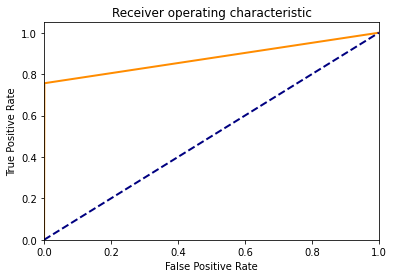

In [58]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(labels[val_idx], result)

# Plot the curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()